<div style="position: relative; width: 100%; height: 300px; display: flex; justify-content: center; align-items: center;">
    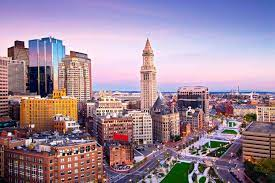
    <div style="border-radius: 10px; position: relative; z-index: 1; text-align: center; background-color: rgba(50, 50, 50, 0.5); color: #FF6961; display: flex; flex-direction: column; align-items: center; text-align: center; justify-content: center; width: 100%; margin: 10%; padding: 5px ">
            <h1 style="text-align: center; width: 100%" >Data Analytics I - Boston Housing Dataset</h1>
            <h3 style="padding-top: 20px"> Atharva Date </h3>
    </div>
</div>

<h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: #ffaa99; background-color: rgba(20, 20, 80, 0.2); padding: 30px; border-style: solid; border-radius: 10px;"> Imports & Load Data </h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()
sns.set_palette('coolwarm')
SNS_CMAP = 'coolwarm'

def highlight_alternate_cells(s):
    return ['background-color: #203080' if i % 2 == 0 else 'background-color: #702020' for i in range(len(s))]

In [20]:
# modes = ['kaggle', 'colab', 'jupyter']
mode = "kaggle"
# types = ["contest", "dataset"]
type = "dataset"
contest_name = "boston-housing-dataset"

In [27]:
import os
if mode=="colab":
    !pip install opendatasets
    import opendatasets as od
    od.download('https://www.kaggle.com/datasets/altavish/boston-housing-dataset')

if mode=="kaggle":
    base_path = f'/kaggle/input/{contest_name}'
    if type == "dataset":
        data_name = os.listdir(base_path)[0]
        df = pd.read_csv(os.path.join(base_path, data_name))
    else:
        df = pd.read_csv(os.path.join(base_path, 'train.csv'))
        df_test = pd.read_csv(os.path.join(base_path, 'test.csv'))
        df_sample = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))
else:
    base_path = f'/content/{contest_name}'

<h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: #ffaa99; background-color: rgba(20, 20, 80, 0.2); padding: 30px; border-style: solid; border-radius: 10px;"> EDA </h1>

In [28]:
df.head().style.background_gradient(cmap='coolwarm')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.006320,18.000000,2.310000,0.000000,0.538000,6.575000,65.200000,4.090000,1,296,15.300000,396.900000,4.980000,24.000000
1,0.027310,0.000000,7.070000,0.000000,0.469000,6.421000,78.900000,4.967100,2,242,17.800000,396.900000,9.140000,21.600000
2,0.027290,0.000000,7.070000,0.000000,0.469000,7.185000,61.100000,4.967100,2,242,17.800000,392.830000,4.030000,34.700000
3,0.032370,0.000000,2.180000,0.000000,0.458000,6.998000,45.800000,6.062200,3,222,18.700000,394.630000,2.940000,33.400000
4,0.069050,0.000000,2.180000,0.000000,0.458000,7.147000,54.200000,6.062200,3,222,18.700000,396.900000,nan,36.200000


In [29]:
df.describe().iloc[1:].style.background_gradient(cmap='coolwarm_r')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [32]:
agg_df = df.agg(["nunique", "unique", lambda x:x.isna().sum(), "dtypes"]).T
agg_df['unique'] = agg_df['unique'].apply(lambda x: x if len(x)<10 else x[:10])
agg_df.style.apply(highlight_alternate_cells)

,nunique,unique,,dtypes
CRIM,484,[0.00632 0.02731 0.02729 0.03237 0.06905 0.02985 0.08829 0.14455 0.21124 0.17004],20,float64
ZN,26,[ 18. 0. 12.5 75. 21. 90. 85. 100. 25. 17.5],20,float64
INDUS,76,[2.31 7.07 2.18 7.87 8.14 5.96 nan 2.95 6.91 5.64],20,float64
CHAS,2,[ 0. nan 1.],20,float64
NOX,81,[0.538 0.469 0.458 0.524 0.499 0.428 0.448 0.439 0.41 0.403],0,float64
RM,446,[6.575 6.421 7.185 6.998 7.147 6.43 6.012 6.172 5.631 6.004],0,float64
AGE,348,[ 65.2 78.9 61.1 45.8 54.2 58.7 66.6 96.1 100. 85.9],20,float64
DIS,412,[4.09 4.9671 6.0622 5.5605 5.9505 6.0821 6.5921 6.3467 6.2267 5.4509],0,float64
RAD,9,[ 1 2 3 5 4 8 6 7 24],0,int64
TAX,66,[296 242 222 311 307 279 252 233 243 469],0,int64


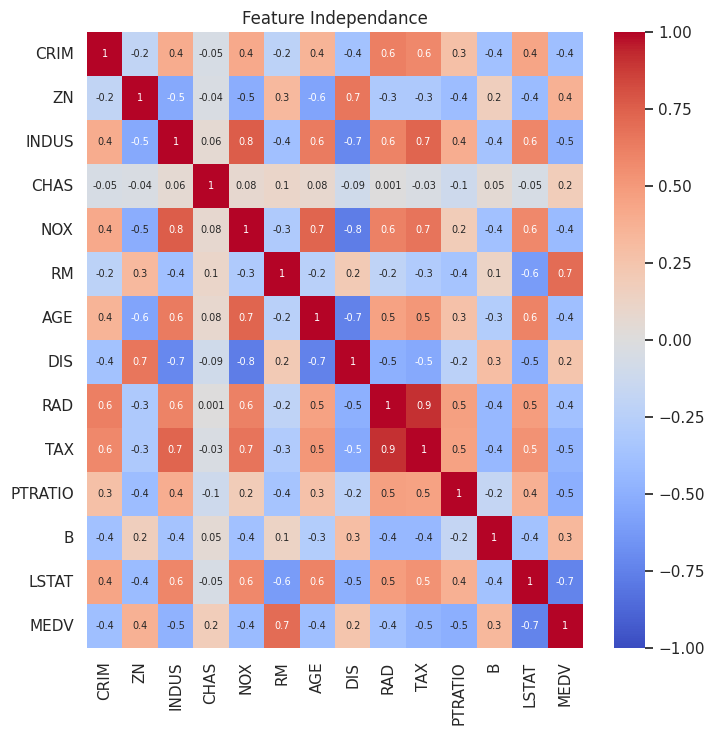

In [33]:
plt.figure(figsize=(8, 8))
plt.title("Feature Independance")
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
sns.heatmap(df.select_dtypes(include=numerics).corr(), cmap=SNS_CMAP, annot=True, annot_kws={'fontsize':7}, fmt='.1g', vmin=-1, vmax=1, center= 0)
plt.show()

In [34]:
numeric_cols = df.select_dtypes(include=['number']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns 
cols = numeric_cols
n_columns = len(cols)
fig,axes = plt.subplots(n_columns, 2,figsize=(10, 10),dpi=300)
for i, col in enumerate(cols):
    sns.kdeplot(data = df, x=col, fill=True, ax=axes[i][0])
    sns.boxplot(x=df[col], ax=axes[i][1])
fig.tight_layout()
plt.show()

<h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: #ffaa99; background-color: rgba(20, 20, 80, 0.2); padding: 30px; border-style: solid; border-radius: 10px;"> PreProcessing </h1>

<div style=" margin: 0% 20%; text-align: center; font-family: 'Roboto', sans-serif; color: #8099ba; background-color: rgba(200, 170, 170, 0.2); padding: 20px; border-style: solid; border-radius: 10px;"> <p>We can clearly see that there are no categorical columns and we will therefore not need encoding unless we perform binning on numeric data. However we will require imputation.</p></div>

<h3 style="text-align: center; font-family: 'Roboto', sans-serif; color: #cc6655; background-color: rgba(40, 40, 90, 0.2); padding: 10px; border-style: solid; border-radius: 10px;"> Imputation </h3>

In [36]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
imp.fit(df)
df = pd.DataFrame(imp.transform(df), columns=df.columns)

<h3 style="text-align: center; font-family: 'Roboto', sans-serif; color: #cc6655; background-color: rgba(40, 40, 90, 0.2); padding: 10px; border-style: solid; border-radius: 10px;"> Scaling </h3>

In [40]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(df)
df = pd.DataFrame(mms.transform(df), columns=df.columns)

<h3 style="text-align: center; font-family: 'Roboto', sans-serif; color: #cc6655; background-color: rgba(40, 40, 90, 0.2); padding: 10px; border-style: solid; border-radius: 10px;"> Pipeline </h3>

In [47]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('imputer', imp),  
    ('scaler', mms),
])
pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])

<h3 style="text-align: center; font-family: 'Roboto', sans-serif; color: #cc6655; background-color: rgba(40, 40, 90, 0.2); padding: 10px; border-style: solid; border-radius: 10px;"> Train-Test-Split </h3>

In [50]:
X, Y = df.drop(['MEDV'], axis=1).values, df['MEDV'].values

In [51]:
X.shape, Y.shape

((506, 13), (506,))

In [52]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

<h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: #ffaa99; background-color: rgba(20, 20, 80, 0.2); padding: 30px; border-style: solid; border-radius: 10px;"> Linear Regression </h1>

In [54]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [55]:
lr.score(x_test, y_test)

0.7661540753641893